# Active Learning for Gaussian Process Classification Model

In [1]:
import gpflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import trieste
from trieste.acquisition.function import BayesianActiveLearningByDisagreement
from trieste.acquisition.rule import OBJECTIVE
from trieste.models.gpflow.models import VariationalGaussianProcess
from trieste.objectives.utils import mk_observer

np.random.seed(1793)
tf.random.set_seed(1793)

## The problem

In Trieste, it is also possible to query most interesting points for learning the problem, i.e we want to have as little data as possible to construct the best possible model (active learning). In this tutorial we will try to do active learning for binary classification problem using Bayesain Active Learning by Disagreement (BALD) for a Gaussian Process Classification Model.

We will illustrate the BALD algorithm on a synthetic binary classification problem where one class takes shape of a circle in the search space. The input space is continuous so we can use continuous optimiser for our BALD acquisition function.

In [2]:
search_space = trieste.space.Box([-1, -1], [1, 1])
input_dim = 2


def circle(x):
    return tf.cast(
        (tf.reduce_sum(tf.square(x), axis=1, keepdims=True) - 0.5) > 0,
        tf.float64,
    )

Let's first illustrate how this two dimensional problem looks like. Class 1 is the area outside of the circle and class 0 is area inside the circle.

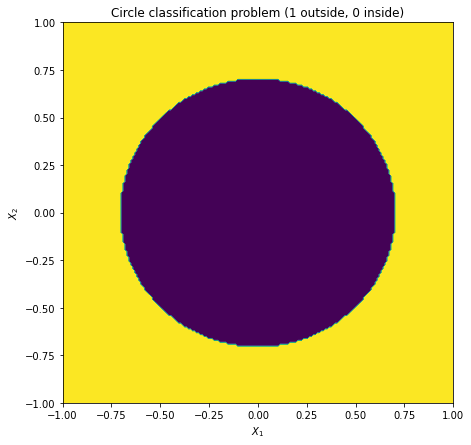

In [3]:
from util.plotting import plot_function_2d

_, ax = plot_function_2d(
    circle,
    search_space.lower,
    search_space.upper,
    grid_density=200,
    contour=True,
    figsize=(7, 7),
    title=["Circle classification problem (1 outside, 0 inside)"],
    xlabel="$X_1$",
    ylabel="$X_2$",
    fill=True,
)
plt.show()

Let's generate some data for our initial model. Here we randomly sample a small number of data points.

In [4]:
num_initial_points = 5
X = search_space.sample(num_initial_points)
observer = mk_observer(circle)
initial_data = observer(X)

## Modelling the binary classification task

For the binary classification model, we use the Variational Gaussian Process with Bernoulli likelihood. For more detail of this model, see <cite data-cite="Nickisch08a">[Nickisch et al.](https://www.jmlr.org/papers/volume9/nickisch08a/nickisch08a.pdf)</cite>. Here we use trieste's gpflow model builder `build_vgp_classifier`.
User can also use Sparse Variational Gaussian Process(SVGP) for building the classification model via `build_svgp` function and `SparseVariational` class. SVGP is preferable for bigger amount of data.

In [5]:
from trieste.models.gpflow import VariationalGaussianProcess
from trieste.models.gpflow.builders import build_vgp_classifier

model = VariationalGaussianProcess(
    build_vgp_classifier(initial_data, search_space, noise_free=True)
)

Lets see our model landscape using only those initial data

In [6]:
from util.plotting_plotly import (
    plot_model_predictions_plotly,
    add_bo_points_plotly,
)

model.update(initial_data)
model.optimize(initial_data)

fig = plot_model_predictions_plotly(
    model,
    search_space.lower,
    search_space.upper,
)

fig = add_bo_points_plotly(
    x=initial_data.query_points[:, 0],
    y=initial_data.query_points[:, 1],
    z=initial_data.observations[:, 0],
    num_init=num_initial_points,
    fig=fig,
    figrow=1,
    figcol=1,
)
fig.show()

## The acquisition process

We can construct the BALD acquisition function which maximises information gain about the model parameters, by maximising the mutual information between predictions and model posterior:

$$\mathbb{I}\left[y, \boldsymbol{\theta} \mid \mathbf{x}, \mathcal{D}\right]=\mathbb{H}\left[y \mid \mathbf{x}, \mathcal{D}\right]-\mathbb{E}_{p\left(\boldsymbol{\theta} \mid \mathcal{D}\right)}[\mathbb{H}[y \mid \mathbf{x}, \boldsymbol{\theta}]]$$

See <cite data-cite="houlsby2011bayesian">[Houlsby et al.](https://arxiv.org/pdf/1112.5745.pdf)</cite> for more details. Then, Trieste's `EfficientGlobalOptimization` is used for the query rule:

In [7]:
acq = BayesianActiveLearningByDisagreement()
rule = trieste.acquisition.rule.EfficientGlobalOptimization(acq)  # type: ignore

## Run the active learning loop
Let's run our active learning iteration:

In [8]:
num_steps = 30
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
results = bo.optimize(num_steps, initial_data, model, rule)
final_dataset = results.try_get_final_datasets()[OBJECTIVE]
final_model = results.try_get_final_models()[OBJECTIVE]

Optimization completed without errors


## Visualising the result
Now, we can visualize our model after the active learning run. Points marked with a cross are initial points while circles are points queried by the optimizer.

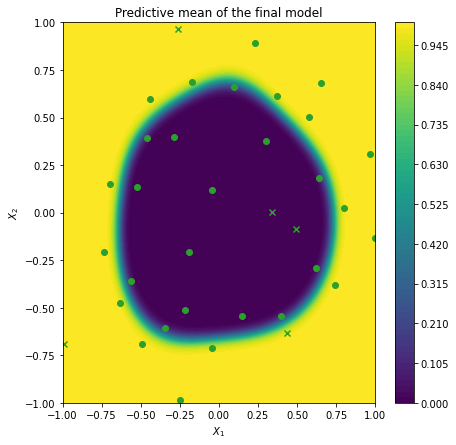

In [9]:
from util.plotting import plot_bo_points

_, ax = plot_function_2d(
    lambda x: gpflow.likelihoods.Bernoulli().invlink(final_model.predict(x)[0]),
    search_space.lower,
    search_space.upper,
    grid_density=200,
    contour=True,
    colorbar=True,
    figsize=(7, 7),
    title=["Predictive mean of the final model"],
    xlabel="$X_1$",
    ylabel="$X_2$",
    fill=True,
)
plot_bo_points(final_dataset.query_points, ax[0, 0], num_initial_points)
plt.show()

As expected, BALD will query in important regions like points near the domain boundary and class boundary.

## LICENSE

[Apache License 2.0](https://github.com/secondmind-labs/trieste/blob/develop/LICENSE)